# Bulk vs Peculiar Motion: Reference Frame Analysis

**Separating coherent bulk flow from individual thermal motion**

## The Problem

Our previous diffusion analysis (12.2f) measured token displacements in the **lab frame** (fixed coordinates). But tokens could be moving for two different reasons:

1. **Bulk flow:** The entire token cloud drifting together (like wind carrying a swarm)
2. **Peculiar motion:** Individual tokens wandering relative to the cloud's center of mass

## The Solution

We decompose motion into:

$$\vec{v}_{\text{lab}} = \vec{v}_{\text{bulk}} + \vec{v}_{\text{peculiar}}$$

Where:
- **Bulk velocity** = motion of the centroid (center of mass)
- **Peculiar velocity** = motion relative to centroid

## Hypothesis

If dead tokens are "passive passengers":
- Large lab-frame motion (carried by bulk flow)
- Small peculiar motion (not actually learning)

If live tokens are "active swimmers":
- Large peculiar motion (driven by gradients)

## Parameters

In [1]:
# Data source - change this to analyze different runs
TRAINING_DATA_PATH = '../tensors/Lil_Gatsby/1.9d_training_data.safetensors'
RUN_NAME = '1.9d (vanilla SGD, lr=0.1, batch=1)'

# Analysis
N_STEPS = 1000  # Number of training steps to analyze (not including init)

# Visualization
DPI = 100
COLORMAP = 'inferno'

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from scipy import stats

## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f'Using device: {device}')

Using device: mps


## Load Data

In [4]:
data = load_file(TRAINING_DATA_PATH)
embeddings = data['embeddings']  # (n_steps, 128, 64)

# Load token categories
DEAD_TOKENS = data['dead_token_ids'].cpu().numpy() if 'dead_token_ids' in data else None
LIVE_TOKENS = data['live_token_ids'].cpu().numpy() if 'live_token_ids' in data else None

if DEAD_TOKENS is not None:
    print(f'Loaded {len(DEAD_TOKENS)} dead tokens from file')
if LIVE_TOKENS is not None:
    print(f'Loaded {len(LIVE_TOKENS)} live tokens from file')

print(f'Loaded: {RUN_NAME}')
print(f'Embeddings shape: {embeddings.shape}')
print(f'Analyzing first {N_STEPS} steps')
print()

# Validate N_STEPS
if N_STEPS + 1 > embeddings.shape[0]:
    N_STEPS = embeddings.shape[0] - 1
    print(f'Adjusted to {N_STEPS} steps (max available)')
    print()

n_tokens = embeddings.shape[1]
embedding_dim = embeddings.shape[2]

Loaded 50 dead tokens from file
Loaded 78 live tokens from file
Loaded: 1.9d (vanilla SGD, lr=0.1, batch=1)
Embeddings shape: torch.Size([1001, 128, 64])
Analyzing first 1000 steps



## Compute Centroid Trajectory

In [5]:
print('Computing centroid trajectory...')
print()

# Centroid at each step
centroids = np.zeros((N_STEPS + 1, embedding_dim))  # (1001, 64)

for step_idx in range(N_STEPS + 1):
    emb = embeddings[step_idx].cpu().numpy()  # (128, 64)
    centroids[step_idx] = emb.mean(axis=0)  # (64,)

# Bulk displacements (centroid motion)
bulk_displacements = np.diff(centroids, axis=0)  # (1000, 64)
bulk_displacement_norms = np.linalg.norm(bulk_displacements, axis=1)  # (1000,)

# Total centroid displacement
total_centroid_displacement = centroids[-1] - centroids[0]
total_centroid_distance = np.linalg.norm(total_centroid_displacement)

print(f'✓ Computed centroid trajectory')
print()
print('Centroid motion:')
print(f'  Total displacement: {total_centroid_distance:.6f}')
print(f'  Mean step size: {bulk_displacement_norms.mean():.6f}')
print(f'  Max step size: {bulk_displacement_norms.max():.6f}')
print(f'  Min step size: {bulk_displacement_norms.min():.6f}')

Computing centroid trajectory...

✓ Computed centroid trajectory

Centroid motion:
  Total displacement: 0.138276
  Mean step size: 0.000201
  Max step size: 0.001541
  Min step size: 0.000000


## Compute Peculiar Motions (Bulk Rest Frame)

In [6]:
print('Computing peculiar motions (bulk rest frame)...')
print()

# For each token, compute displacement in bulk rest frame
# peculiar_displacement[t, tok] = (emb[t+1, tok] - emb[t, tok]) - bulk_displacement[t]

peculiar_step_norms = np.zeros((N_STEPS, n_tokens))  # (1000, 128)

for step_idx in range(N_STEPS):
    emb_curr = embeddings[step_idx].cpu().numpy()  # (128, 64)
    emb_next = embeddings[step_idx + 1].cpu().numpy()  # (128, 64)
    
    # Lab-frame displacement
    lab_displacement = emb_next - emb_curr  # (128, 64)
    
    # Subtract bulk motion
    bulk_motion = bulk_displacements[step_idx]  # (64,)
    peculiar_displacement = lab_displacement - bulk_motion[np.newaxis, :]  # (128, 64)
    
    # Norms
    peculiar_step_norms[step_idx] = np.linalg.norm(peculiar_displacement, axis=1)  # (128,)

print(f'✓ Computed peculiar motions for {N_STEPS} steps, {n_tokens} tokens')
print()

# Statistics
all_peculiar_norms = peculiar_step_norms.flatten()
sigma_peculiar_rms = np.sqrt(np.mean(all_peculiar_norms ** 2))
sigma_peculiar_mean = all_peculiar_norms.mean()

print('Peculiar motion statistics:')
print(f'  Mean: {sigma_peculiar_mean:.6f}')
print(f'  RMS: {sigma_peculiar_rms:.6f}')
print(f'  Max: {all_peculiar_norms.max():.6f}')

Computing peculiar motions (bulk rest frame)...

✓ Computed peculiar motions for 1000 steps, 128 tokens

Peculiar motion statistics:
  Mean: 0.001580
  RMS: 0.004627
  Max: 0.077711


## Compute Final Displacements (Both Frames)

In [7]:
print('Computing final displacements in both reference frames...')
print()

# Initial and final positions
emb_init = embeddings[0].cpu().numpy()  # (128, 64)
emb_final = embeddings[N_STEPS].cpu().numpy()  # (128, 64)

# LAB FRAME: Total displacement
lab_displacement = emb_final - emb_init  # (128, 64)
lab_distances = np.linalg.norm(lab_displacement, axis=1)  # (128,)

# BULK REST FRAME: Displacement relative to initial centroid position
# Each token's position relative to centroid
init_relative = emb_init - centroids[0][np.newaxis, :]  # (128, 64)
final_relative = emb_final - centroids[N_STEPS][np.newaxis, :]  # (128, 64)

peculiar_displacement = final_relative - init_relative  # (128, 64)
peculiar_distances = np.linalg.norm(peculiar_displacement, axis=1)  # (128,)

print(f'✓ Computed final displacements for {n_tokens} tokens')
print()
print('Lab frame (absolute coordinates):')
print(f'  Mean distance: {lab_distances.mean():.6f}')
print(f'  Max distance: {lab_distances.max():.6f}')
print()
print('Bulk rest frame (relative to centroid):')
print(f'  Mean distance: {peculiar_distances.mean():.6f}')
print(f'  Max distance: {peculiar_distances.max():.6f}')

Computing final displacements in both reference frames...

✓ Computed final displacements for 128 tokens

Lab frame (absolute coordinates):
  Mean distance: 0.221472
  Max distance: 0.862639

Bulk rest frame (relative to centroid):
  Mean distance: 0.252720
  Max distance: 0.736488


## Diffusivity in Both Frames

In [8]:
print('Computing diffusivity ratios in both frames...')
print()

# Lab frame diffusivity (from 12.2f)
# First compute lab-frame step size statistics
lab_step_norms = np.zeros((N_STEPS, n_tokens))
for step_idx in range(N_STEPS):
    emb_curr = embeddings[step_idx].cpu().numpy()
    emb_next = embeddings[step_idx + 1].cpu().numpy()
    lab_step_norms[step_idx] = np.linalg.norm(emb_next - emb_curr, axis=1)

sigma_lab_rms = np.sqrt(np.mean(lab_step_norms ** 2))

expected_lab = np.sqrt(N_STEPS) * sigma_lab_rms
D_lab = (lab_distances ** 2) / (N_STEPS * sigma_lab_rms ** 2)

# Bulk rest frame diffusivity
expected_peculiar = np.sqrt(N_STEPS) * sigma_peculiar_rms
D_peculiar = (peculiar_distances ** 2) / (N_STEPS * sigma_peculiar_rms ** 2)

print('Lab frame:')
print(f'  σ (RMS step): {sigma_lab_rms:.6f}')
print(f'  Expected displacement: {expected_lab:.6f}')
print(f'  Mean D: {D_lab.mean():.4f}')
print(f'  Median D: {np.median(D_lab):.4f}')
print()
print('Bulk rest frame:')
print(f'  σ (RMS step): {sigma_peculiar_rms:.6f}')
print(f'  Expected displacement: {expected_peculiar:.6f}')
print(f'  Mean D: {D_peculiar.mean():.4f}')
print(f'  Median D: {np.median(D_peculiar):.4f}')

Computing diffusivity ratios in both frames...

Lab frame:
  σ (RMS step): 0.004636
  Expected displacement: 0.146601
  Mean D: 4.8347
  Median D: 0.2178

Bulk rest frame:
  σ (RMS step): 0.004627
  Expected displacement: 0.146310
  Mean D: 3.9607
  Median D: 1.9189


## Bulk vs Peculiar Comparison

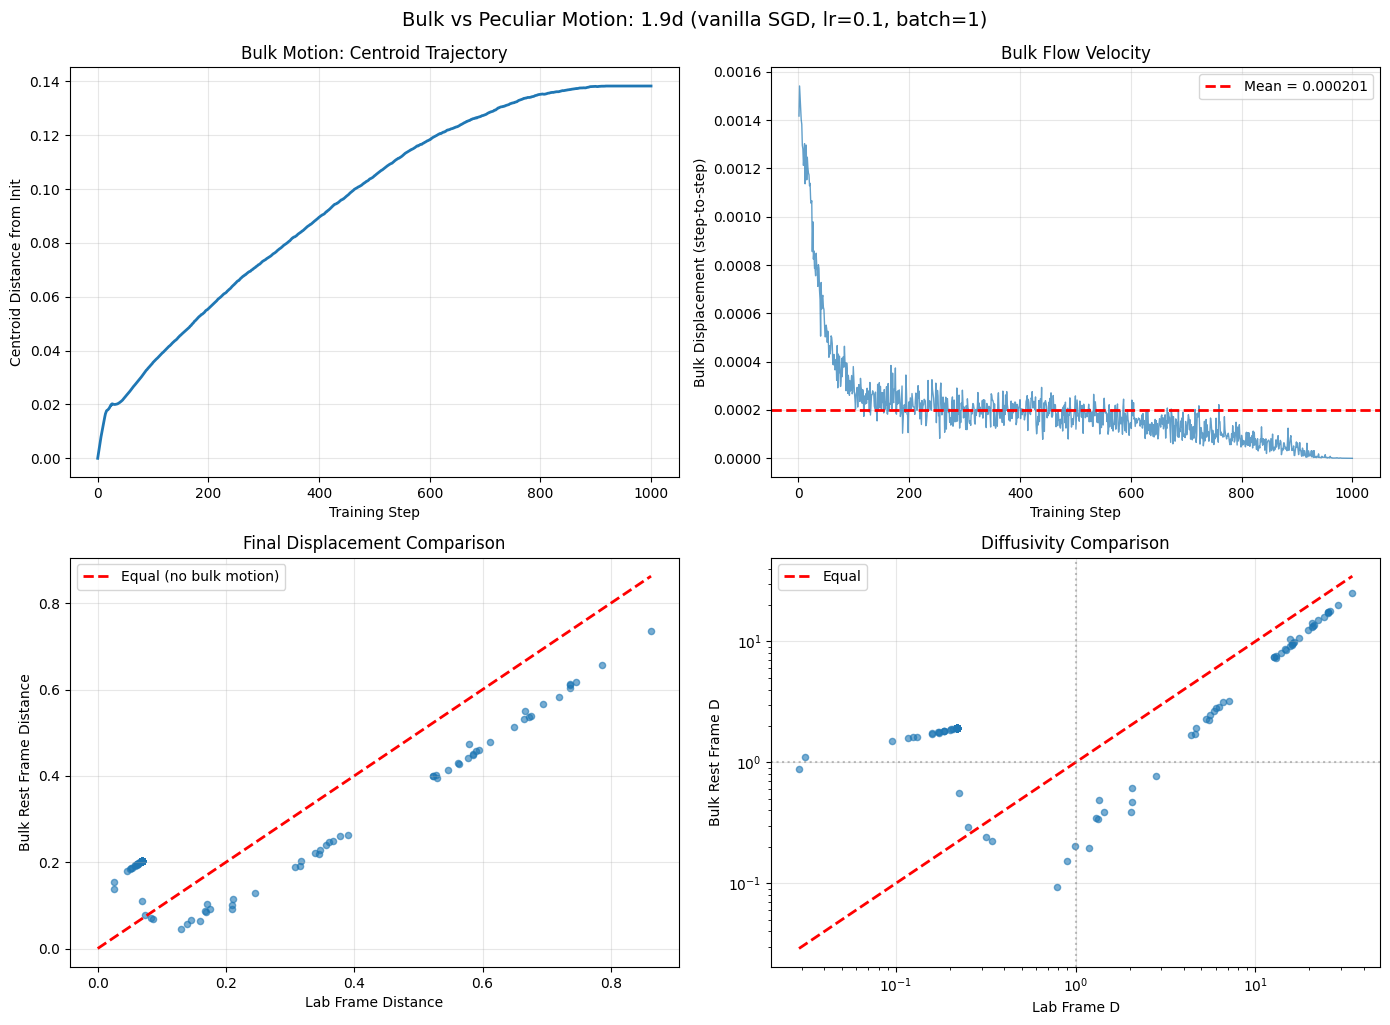

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=DPI)

# Top-left: Centroid trajectory norm over time
ax = axes[0, 0]
centroid_distances = np.linalg.norm(centroids - centroids[0], axis=1)
ax.plot(range(N_STEPS + 1), centroid_distances, linewidth=2)
ax.set_xlabel('Training Step')
ax.set_ylabel('Centroid Distance from Init')
ax.set_title('Bulk Motion: Centroid Trajectory')
ax.grid(alpha=0.3)

# Top-right: Bulk displacement per step
ax = axes[0, 1]
ax.plot(range(1, N_STEPS + 1), bulk_displacement_norms, linewidth=1, alpha=0.7)
ax.axhline(bulk_displacement_norms.mean(), color='r', linestyle='--', 
           linewidth=2, label=f'Mean = {bulk_displacement_norms.mean():.6f}')
ax.set_xlabel('Training Step')
ax.set_ylabel('Bulk Displacement (step-to-step)')
ax.set_title('Bulk Flow Velocity')
ax.legend()
ax.grid(alpha=0.3)

# Bottom-left: Lab frame vs bulk rest frame distances
ax = axes[1, 0]
ax.scatter(lab_distances, peculiar_distances, s=20, alpha=0.6)
ax.plot([0, lab_distances.max()], [0, lab_distances.max()], 'r--', 
        linewidth=2, label='Equal (no bulk motion)')
ax.set_xlabel('Lab Frame Distance')
ax.set_ylabel('Bulk Rest Frame Distance')
ax.set_title('Final Displacement Comparison')
ax.legend()
ax.grid(alpha=0.3)

# Bottom-right: Diffusivity comparison
ax = axes[1, 1]
ax.scatter(D_lab, D_peculiar, s=20, alpha=0.6)
ax.plot([D_lab.min(), D_lab.max()], [D_lab.min(), D_lab.max()], 'r--', 
        linewidth=2, label='Equal')
ax.axhline(1.0, color='gray', linestyle=':', alpha=0.5)
ax.axvline(1.0, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Lab Frame D')
ax.set_ylabel('Bulk Rest Frame D')
ax.set_title('Diffusivity Comparison')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle(f'Bulk vs Peculiar Motion: {RUN_NAME}', y=1.02, fontsize=14)
plt.show()

## Dead vs Live Tokens: Reference Frame Analysis

DEAD vs LIVE TOKENS: REFERENCE FRAME ANALYSIS

LAB FRAME (absolute coordinates):
  Dead tokens mean distance: 0.068422
  Live tokens mean distance: 0.319580
  Ratio (live/dead): 4.67x

BULK REST FRAME (relative to centroid):
  Dead tokens mean distance: 0.202666
  Live tokens mean distance: 0.284806
  Ratio (live/dead): 1.41x

DIFFUSIVITY:
  Lab frame - Dead: D = 0.2178
  Lab frame - Live: D = 7.7943
  Rest frame - Dead: D = 1.9187
  Rest frame - Live: D = 5.2697

PECULIAR vs LAB MOTION:
  Dead tokens: 296.2% peculiar, -196.2% bulk
  Live tokens: 154.1% peculiar, -54.1% bulk



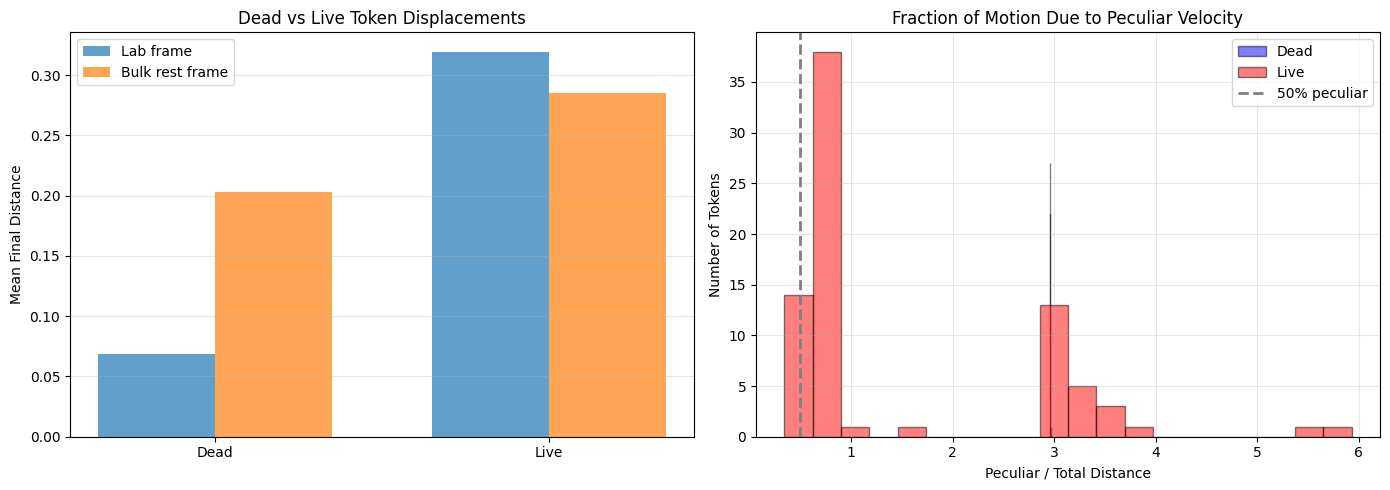

In [10]:
if DEAD_TOKENS is not None and LIVE_TOKENS is not None:
    dead_mask = np.isin(np.arange(n_tokens), DEAD_TOKENS)
    live_mask = np.isin(np.arange(n_tokens), LIVE_TOKENS)
    
    print('='*70)
    print('DEAD vs LIVE TOKENS: REFERENCE FRAME ANALYSIS')
    print('='*70)
    print()
    
    # Lab frame
    print('LAB FRAME (absolute coordinates):')
    print(f'  Dead tokens mean distance: {lab_distances[dead_mask].mean():.6f}')
    print(f'  Live tokens mean distance: {lab_distances[live_mask].mean():.6f}')
    print(f'  Ratio (live/dead): {lab_distances[live_mask].mean() / lab_distances[dead_mask].mean():.2f}x')
    print()
    
    # Bulk rest frame
    print('BULK REST FRAME (relative to centroid):')
    print(f'  Dead tokens mean distance: {peculiar_distances[dead_mask].mean():.6f}')
    print(f'  Live tokens mean distance: {peculiar_distances[live_mask].mean():.6f}')
    print(f'  Ratio (live/dead): {peculiar_distances[live_mask].mean() / peculiar_distances[dead_mask].mean():.2f}x')
    print()
    
    # Diffusivity
    print('DIFFUSIVITY:')
    print(f'  Lab frame - Dead: D = {D_lab[dead_mask].mean():.4f}')
    print(f'  Lab frame - Live: D = {D_lab[live_mask].mean():.4f}')
    print(f'  Rest frame - Dead: D = {D_peculiar[dead_mask].mean():.4f}')
    print(f'  Rest frame - Live: D = {D_peculiar[live_mask].mean():.4f}')
    print()
    
    # Key insight: ratio of peculiar to lab motion
    peculiar_fraction_dead = peculiar_distances[dead_mask] / lab_distances[dead_mask]
    peculiar_fraction_live = peculiar_distances[live_mask] / lab_distances[live_mask]
    
    print('PECULIAR vs LAB MOTION:')
    print(f'  Dead tokens: {peculiar_fraction_dead.mean():.1%} peculiar, {(1-peculiar_fraction_dead.mean()):.1%} bulk')
    print(f'  Live tokens: {peculiar_fraction_live.mean():.1%} peculiar, {(1-peculiar_fraction_live.mean()):.1%} bulk')
    print()
    print('='*70)
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)
    
    # Left: Distance comparison
    ax = axes[0]
    x = np.arange(2)
    width = 0.35
    ax.bar(x - width/2, [lab_distances[dead_mask].mean(), lab_distances[live_mask].mean()],
           width, label='Lab frame', alpha=0.7)
    ax.bar(x + width/2, [peculiar_distances[dead_mask].mean(), peculiar_distances[live_mask].mean()],
           width, label='Bulk rest frame', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(['Dead', 'Live'])
    ax.set_ylabel('Mean Final Distance')
    ax.set_title('Dead vs Live Token Displacements')
    ax.legend()
    ax.grid(alpha=0.3, axis='y')
    
    # Right: Peculiar fraction
    ax = axes[1]
    ax.hist(peculiar_fraction_dead, bins=20, alpha=0.5, label='Dead', color='blue', edgecolor='black')
    ax.hist(peculiar_fraction_live, bins=20, alpha=0.5, label='Live', color='red', edgecolor='black')
    ax.axvline(0.5, color='gray', linestyle='--', linewidth=2, label='50% peculiar')
    ax.set_xlabel('Peculiar / Total Distance')
    ax.set_ylabel('Number of Tokens')
    ax.set_title('Fraction of Motion Due to Peculiar Velocity')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print('No dead/live token labels available')

## Interpretation: Are Dead Tokens Passive Passengers?

In [11]:
if DEAD_TOKENS is not None and LIVE_TOKENS is not None:
    print('='*70)
    print('PASSIVE PASSENGER TEST')
    print('='*70)
    print()
    print('Hypothesis: Dead tokens are passive passengers (carried by bulk flow)')
    print('Prediction: Dead tokens should have low peculiar motion')
    print()
    
    dead_peculiar_mean = peculiar_distances[dead_mask].mean()
    live_peculiar_mean = peculiar_distances[live_mask].mean()
    centroid_distance = total_centroid_distance
    
    print(f'Centroid moved: {centroid_distance:.6f}')
    print(f'Dead tokens peculiar motion: {dead_peculiar_mean:.6f} ({dead_peculiar_mean/centroid_distance:.1%} of centroid)')
    print(f'Live tokens peculiar motion: {live_peculiar_mean:.6f} ({live_peculiar_mean/centroid_distance:.1%} of centroid)')
    print()
    
    # Verdict
    if dead_peculiar_mean < 0.3 * centroid_distance:
        print('✓ HYPOTHESIS SUPPORTED: Dead tokens are mostly passive')
        print('  → Their motion is dominated by bulk flow')
        print('  → They are not actively learning (no strong peculiar kicks)')
    else:
        print('✗ HYPOTHESIS REJECTED: Dead tokens have significant peculiar motion')
        print('  → They are moving independently of bulk flow')
    
    print()
    
    if live_peculiar_mean > 2 * dead_peculiar_mean:
        print('✓ Live tokens show {:.1f}x more peculiar motion than dead'.format(live_peculiar_mean / dead_peculiar_mean))
        print('  → This is the gradient signal (active learning)')
    
    print('='*70)

PASSIVE PASSENGER TEST

Hypothesis: Dead tokens are passive passengers (carried by bulk flow)
Prediction: Dead tokens should have low peculiar motion

Centroid moved: 0.138276
Dead tokens peculiar motion: 0.202666 (146.6% of centroid)
Live tokens peculiar motion: 0.284806 (206.0% of centroid)

✗ HYPOTHESIS REJECTED: Dead tokens have significant peculiar motion
  → They are moving independently of bulk flow



## Per-Token Motion Breakdown

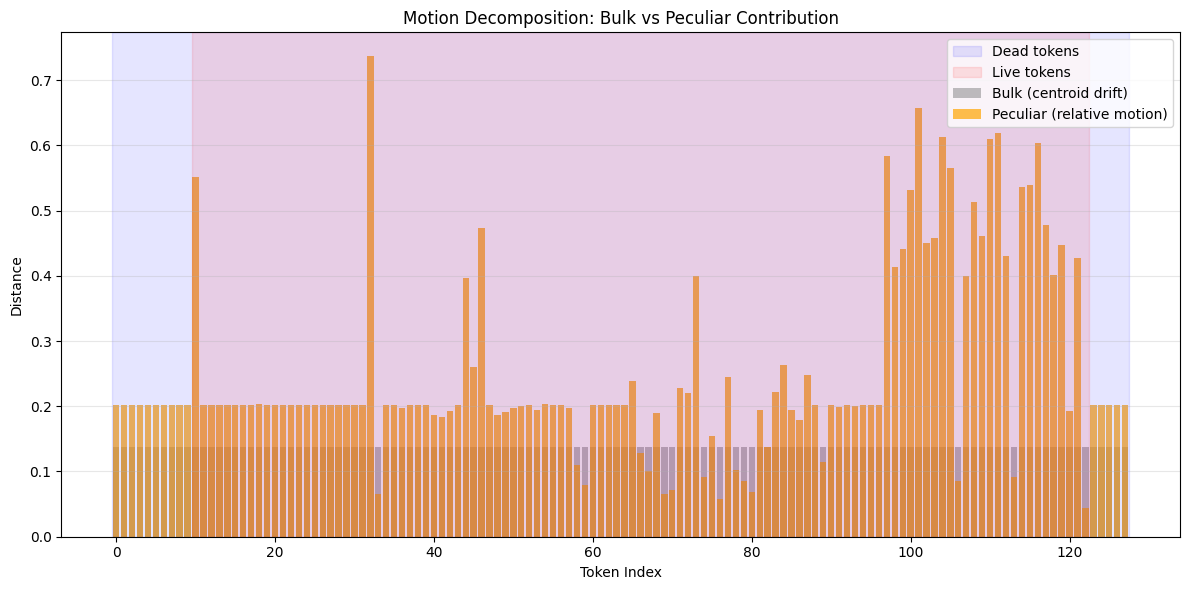

In [12]:
# For each token, decompose its total motion into bulk and peculiar components
# Note: These don't add vectorially, so we use distances (scalars)

# Bulk contribution: how far would token move if it just followed centroid?
bulk_contribution = np.full(n_tokens, total_centroid_distance)

# Actual total motion
total_motion = lab_distances

# Peculiar contribution
peculiar_contribution = peculiar_distances

fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

x = np.arange(n_tokens)
ax.bar(x, bulk_contribution, label='Bulk (centroid drift)', alpha=0.5, color='gray')
ax.bar(x, peculiar_contribution, bottom=0, label='Peculiar (relative motion)', alpha=0.7, color='orange')

# Mark dead vs live regions
if DEAD_TOKENS is not None:
    ax.axvspan(-0.5, DEAD_TOKENS.max() + 0.5, alpha=0.1, color='blue', label='Dead tokens')
if LIVE_TOKENS is not None:
    ax.axvspan(LIVE_TOKENS.min() - 0.5, LIVE_TOKENS.max() + 0.5, alpha=0.1, color='red', label='Live tokens')

ax.set_xlabel('Token Index')
ax.set_ylabel('Distance')
ax.set_title('Motion Decomposition: Bulk vs Peculiar Contribution')
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()